<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/primer/PyTorch_FizzBuzz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
###################
# Library Imports #
###################

import torch
import torch.nn as nn
import random
from functools import partial

In [182]:
####################
# Dataset creation #
####################

def fizz_buzz(number):
  if number % 3 == 0 and number % 5 == 0:
    return "FizzBuzz"
  elif number % 3 == 0:
    return "Fizz"
  elif number % 5 == 0:
    return "Buzz"
  else:
    return "Number"

def binary_encode(num_digits, number):
    return [int(d) for d in f"{number:0{num_digits}b}"]

def one_hot_encode(categorical_value):
  if categorical_value == "Fizz":
    return 0
  elif categorical_value == "Buzz":
    return 1
  elif categorical_value == "FizzBuzz":
    return 2
  elif categorical_value == "Number":
    return 3
  else:
    raise ValueError(f"Value: {categorical_value} is not supported!")

encode = partial(binary_encode, 13)

numbers = [i for i in range(5000)]

x_raw = numbers
y_raw = list(map(fizz_buzz, [i for i in range(5000)]))

print(x_raw[10:15], y_raw[10:15])

x_enc = list(map(lambda num: encode(num), x_raw))
y_enc = list(map(one_hot_encode, y_raw))

[10, 11, 12, 13, 14] ['Buzz', 'Number', 'Fizz', 'Number', 'Number']


In [ ]:
############################
# Create Train / Test Data #
############################

In [174]:
# this is a inconvenient way of creating a shuffled dataset
temp = list(zip(x_enc, y_enc))
random.shuffle(temp)
X, Y = zip(*temp)
X, Y = list(X), list(Y)

print(X[:5], Y[:5])

x_train, y_train = X[:4200], Y[:4200]
x_test, y_test = X[4200:], Y[4200:]

# we need to move the data to the pytorch universe
inputs = torch.tensor(x_train, dtype=torch.float)
targets = torch.tensor(y_train, dtype=torch.long)

test_inputs = torch.tensor(x_test, dtype=torch.float)
test_targets = torch.tensor(y_test, dtype=torch.long)

[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0], [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0], [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1], [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]] [3, 3, 0, 3, 3]


In [175]:
###################
# Build the model #
###################

net = nn.Sequential(
    nn.Linear(13, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 4)
)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-03)
criterion = nn.CrossEntropyLoss()

In [ ]:
###################
# Train the model #
###################

n_epochs = 1000

for i in range(n_epochs):
  logits = net(inputs)
  loss = criterion(logits, targets)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if i % 50 == 0 or i == 1000 - 1:
    with torch.no_grad():
      test_logits = net(test_inputs)
      test_loss = criterion(test_logits, test_targets)
    print(f"Epoch: {i}, Train loss: {loss.item():.4f}, Test loss:{test_loss.item():.4f} ")

In [183]:
######################
# Evaluate the model #
######################

with torch.no_grad():
    predictions = torch.argmax(test_logits, dim=1)
    accuracy = (predictions == test_targets).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9550


In [213]:
##################################
# Switch to a "batched" training #
##################################

from torch.utils.data import DataLoader, TensorDataset

net = nn.Sequential(
    nn.Linear(13, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 4)
)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-03)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.05)
criterion = nn.CrossEntropyLoss()

batch_size = 64
n_epochs = 150

train_ds = TensorDataset(inputs, targets)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
losses = torch.zeros(n_epochs)

for i in range(n_epochs):
  net.train()
  for inputs_batched, targets_batched in train_loader:
    logits = net(inputs_batched)
    loss = criterion(logits, targets_batched)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  losses[i] = loss.mean().item()

  if i % 10 == 0 or i == n_epochs - 1:
    with torch.no_grad():
      net.eval()
      test_logits = net(test_inputs)
      test_loss = criterion(test_logits, test_targets)
    print(f"Epoch: {i}, Train loss: {loss.item():.4f}, Test loss:{test_loss.item():.4f} ")


Epoch: 0, Train loss: 1.1621, Test loss:1.1300 
Epoch: 10, Train loss: 0.9259, Test loss:1.1303 
Epoch: 20, Train loss: 1.1224, Test loss:0.9835 
Epoch: 30, Train loss: 0.6669, Test loss:0.6305 
Epoch: 40, Train loss: 0.2863, Test loss:0.4573 
Epoch: 50, Train loss: 0.2564, Test loss:0.3541 
Epoch: 60, Train loss: 0.2885, Test loss:0.3059 
Epoch: 70, Train loss: 0.1439, Test loss:0.2930 
Epoch: 80, Train loss: 0.0877, Test loss:0.2411 
Epoch: 90, Train loss: 0.1052, Test loss:0.2199 
Epoch: 100, Train loss: 0.0784, Test loss:0.2140 
Epoch: 110, Train loss: 0.0490, Test loss:0.2016 
Epoch: 120, Train loss: 0.0651, Test loss:0.1714 
Epoch: 130, Train loss: 0.0758, Test loss:0.1530 
Epoch: 140, Train loss: 0.0217, Test loss:0.1429 
Epoch: 149, Train loss: 0.0516, Test loss:0.1437 


In [214]:
######################
# Evaluate the model #
######################

with torch.no_grad():
    test_logits = net(test_inputs)
    test_loss = criterion(test_logits, test_targets)
    preds = torch.argmax(test_logits, dim=1)
    acc = (preds == test_targets).float().mean().item()
print(f"Test accuracy: {acc:.4f}")


Test accuracy: 0.9675


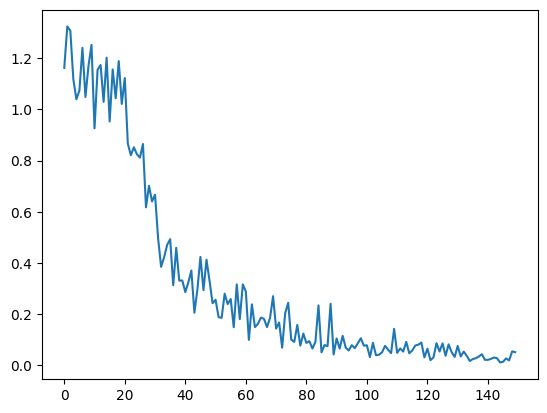

In [215]:
import matplotlib.pyplot as plt

plt.plot(losses)